In [26]:
# Cell 1: Imports and styling
import re
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

plt.style.use("dark_background")


In [27]:
# Cell 2: Load stock symbols from Google Sheets
file_name = "https://drive.google.com/uc?export=download&id=1AmsQ95PffFlcoCkINd8iCxmLYdT1yIQJ"
df = pd.read_csv(file_name)

# Ensure 'Symbol' column exists
if 'Symbol' not in df.columns:
    raise ValueError("CSV file must contain a 'Symbol' column.")

symbols = df["Symbol"].dropna().tolist()
filtered_tickers = [ticker for ticker in symbols if re.match(r'^[A-Z0-9]+$', ticker)]


In [28]:
# Cell 3: Download 6‑month OHLC data and clean
print("Downloading 6‑month stock data...")
ohlc = yf.download(filtered_tickers, period="6mo")["Close"]

# Drop any tickers with no data at all
ohlc = ohlc.dropna(axis=1, how='all')


[*********************100%***********************]  60 of 60 completed


In [29]:
# Cell 4: Calculate daily returns and consistency scores
daily_returns = ohlc.pct_change()
positive_days_ratio = (daily_returns > 0).sum() / daily_returns.count()
positive_days_ratio = positive_days_ratio.dropna().sort_values(ascending=False)


C:\Users\Ahmed's PC\AppData\Local\Temp\ipykernel_11576\3354283116.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = ohlc.pct_change()


In [30]:
# Cell 5: Save consistency scores and display top 10
consistency_df = positive_days_ratio.reset_index()
consistency_df.columns = ['Ticker', 'Positive Return Ratio']
consistency_df.to_csv("momentum_consistency_scores.csv", index=False)

print("\nTop 10 Most Consistent Momentum Stocks:")
display(consistency_df.head(10))



Top 10 Most Consistent Momentum Stocks:


,Ticker,Positive Return Ratio
0,RNMBY,0.634146
1,ESLT,0.601626
2,FINMY,0.601626
3,RNMBF,0.577236
4,SAFRY,0.560976
5,SAABY,0.552846
6,GD,0.544715
7,THLLY,0.544715
8,TGI,0.544715
9,MTUAF,0.536585


C:\Users\Ahmed's PC\AppData\Local\Temp\ipykernel_11576\38679012.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


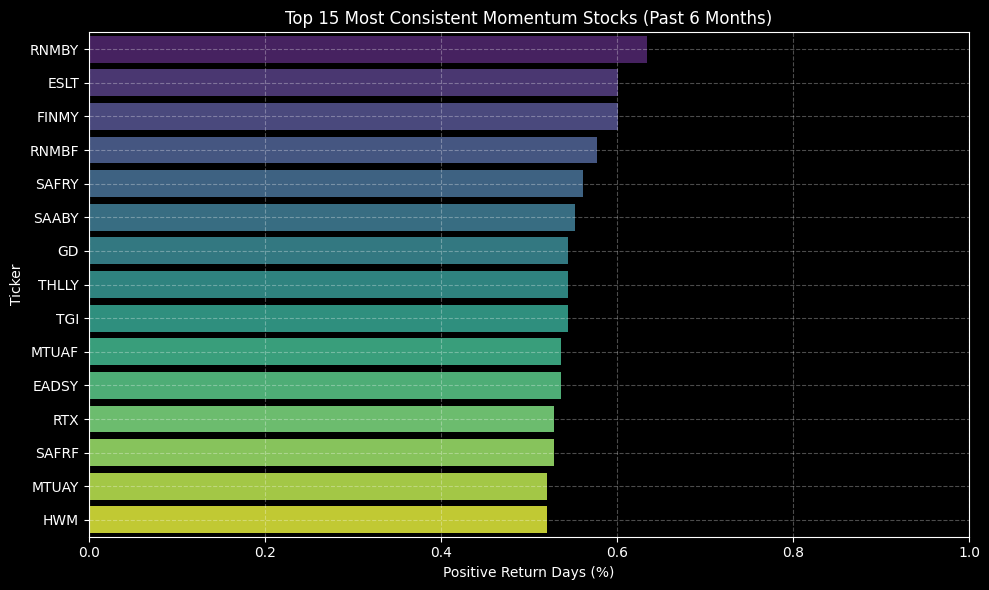

In [31]:
# Cell 6: Bar chart of Top 15 consistent stocks
top_15 = consistency_df.head(15)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_15,
    y="Ticker",
    x="Positive Return Ratio",
    palette="viridis"
)
plt.title("Top 15 Most Consistent Momentum Stocks (Past 6 Months)")
plt.xlabel("Positive Return Days (%)")
plt.ylabel("Ticker")
plt.xlim(0, 1)
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig("top_15_consistency_bar.png")
plt.show()


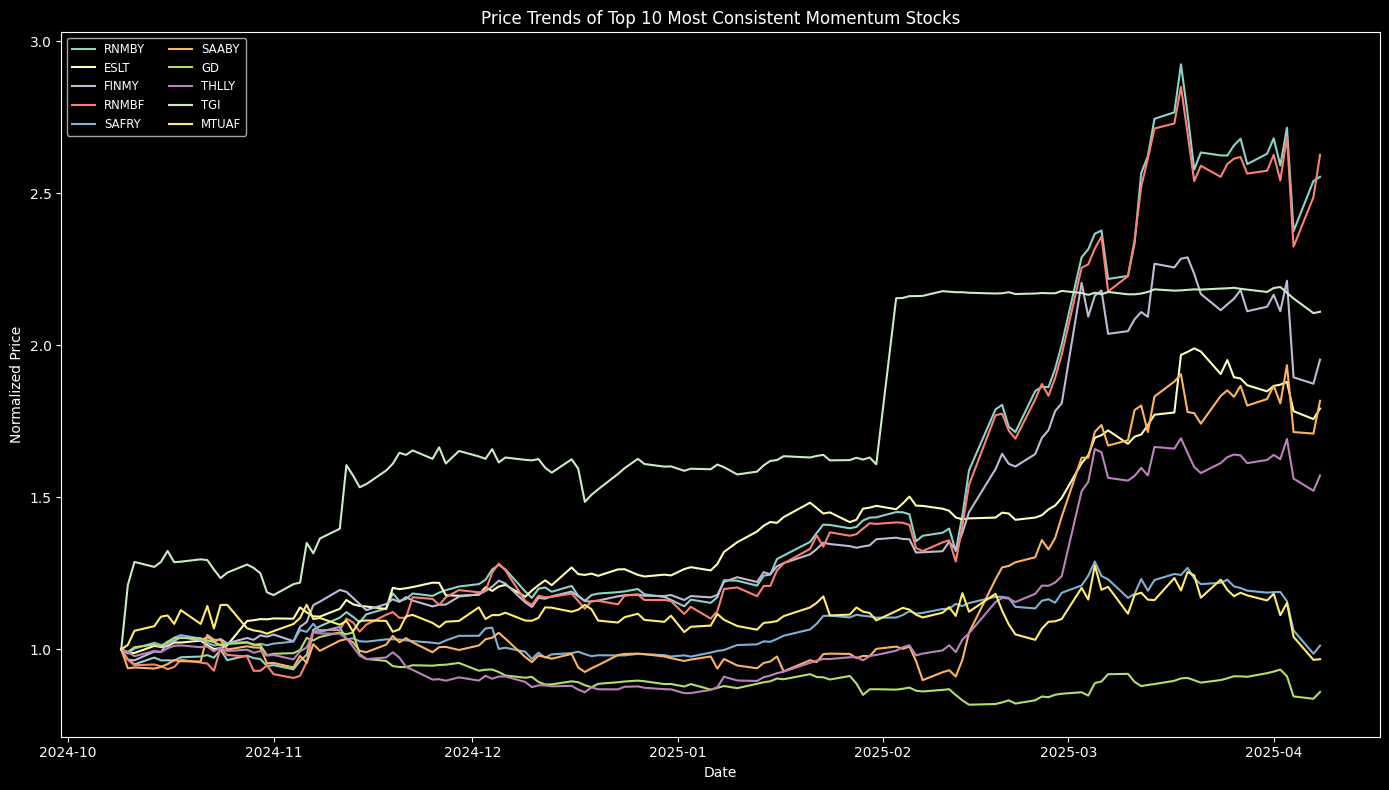

In [32]:
# Cell 7: Line plot of normalized prices for Top 10
plt.figure(figsize=(14, 8))
top_10 = top_15["Ticker"].head(10)

for ticker in top_10:
    series = ohlc[ticker].dropna()              # drop any NaNs
    if series.empty:
        continue
    first_price = series.iloc[0]                # first valid price
    normalized = series / first_price
    plt.plot(normalized.index, normalized.values, label=ticker)

plt.title("Price Trends of Top 10 Most Consistent Momentum Stocks")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend(loc="upper left", fontsize='small', ncol=2)
plt.tight_layout()
plt.savefig("top_10_normalized_price_plot.png")
plt.show()


In [33]:
# Cell 8: Final summary
print("\nAnalysis complete. Results saved as:")
print("- momentum_consistency_scores.csv")
print("- top_15_consistency_bar.png")
print("- top_10_normalized_price_plot.png")



Analysis complete. Results saved as:
- momentum_consistency_scores.csv
- top_15_consistency_bar.png
- top_10_normalized_price_plot.png
